If I have $N$ balls, and I know that since the moment that it is created, the ball will pop with a probablity that follows an exponential decay process. If I know that these $N$ balls are created at different time points, and at a point in time, say 12PM, I count that there are $n$ balls left, given that I know the original number of balls ($N$) and the time difference between the creation of the balls and the current time ${t_i}$, how can I estimate the rate of decay of the balls?
First, we want to establish that if $N$ is small, given ground truth decay rate of the pop process, then we can actually draw out the distribution of the number of balls left at 12PM. Is is Poisson(mean=$\sum_{i=1}^N P(X_i=1) = \sum_{i=1}^N 2^{-t_i/h}$, where $X_i=1$ denotes the event that the $i$th ball remains UNPOPED at 12PM, and $h$ is the half-life of the exponential decay process. 

In [ ]:
# let's show it for the case that N=10, h=5
import numpy as np
import itertools
N=10
max_time = 10
t_i = np.random.uniform(0, max_time, N)
h = 5
p_i = 2**(-t_i/h)
# first, calculate the probability that there are n balls left at 12PM
n = np.arange(0, N+1)
p_n = np.zeros(N+1)
for i in range(N+1):
    # get all the subset of size i of {0,...N}
    for subset in itertools.combinations(range(N), i):
        p_n[i] += np.prod(p_i[list(subset)])*np.prod(1-p_i[list(set(range(N))-set(subset))])
        
# second, let s ~ Poission(mean = \sum_{i=1}^N p_i)
# calculate the probability of s=n for n=0,...,N
def poisson_probabilities(lam, N=10):
    from scipy.stats import poisson
    # Create an array of possible values of s
    s_values = np.arange(0, N+1)
    # Calculate the Poisson probabilities for each value of s
    probabilities = poisson.pmf(s_values, lam)
    # Create a dictionary to store the probabilities
    prob_dict = {n: prob for n, prob in zip(s_values, probabilities)}
    return prob_dict

def normal_probabilities(lam, var, N=10):
    from scipy.stats import norm
    # Create an array of possible values of s
    s_values = np.arange(0, N+1)
    # Calculate the Poisson probabilities for each value of s
    probabilities = norm.pdf(s_values, lam, np.sqrt(var))
    # Create a dictionary to store the probabilities
    prob_dict = {n: prob for n, prob in zip(s_values, probabilities)}
    return prob_dict

lam = np.sum(p_i)
one_minus_p_i = 1-p_i
# variance of the normal distribution
var = np.sum(p_i*one_minus_p_i)
poisson_prob = poisson_probabilities(lam, N)
normal_prob = normal_probabilities(lam, var, N)
# now, draw the p_n and the poisson_prob on the same plot
import matplotlib.pyplot as plt
plt.plot(n, p_n, 'r', label='p_n')
plt.plot(n, [poisson_prob[i] for i in n], 'b', label='poisson_prob')
plt.plot(n, [normal_prob[i] for i in n], 'g', label='normal_prob')
plt.legend()
plt.show()

In [ ]:
# now, given the fixed t_i, N. We will generate n multiple times (like, doing the ball poppoing experiment multiple times) and draw the distribution of n
def do_ballon_pop_exp_multiple_times(N, t_i, h, num_times=1000):
    p_i = 2**(-t_i/h)
    n = np.zeros(num_times)
    for i in range(num_times):
        x_i = np.random.uniform(0, 1, N)
        n[i] = np.sum(x_i < p_i)
    return n


_n = do_ballon_pop_exp_multiple_times(N=N, t_i = t_i, h=h, num_times=10000)
plt.hist(_n, bins=100, density=False)
plt.show()

In [ ]:
# gievn each of these n, can we estimate h using optimization method
from estimate_splice import optimize_h, find_root
_n = do_ballon_pop_exp_multiple_times(N=N, t_i = t_i, h=h, num_times=1000)
plt.hist(_n, bins=100, density=False)
plt.show()
h_hat_opt = np.zeros(len(_n))
h_hat_root = np.zeros(len(_n))
for j in range(len(_n)):
    h_hat_opt[j]= optimize_h([t_i], [_n[j]])
    h_hat_root[j] = find_root([t_i], [_n[j]])
    
# in two plots next to each other, plot the histogram of the estimated h_hat_opt and h_hat_root
fig, axs = plt.subplots(1, 2)
axs[0].hist(h_hat_opt, bins=100, density=False)
axs[1].hist(h_hat_root, bins=100, density=False)
plt.show()

In [4]:

import numpy as np
SEED=9999
np.random.seed(SEED)
from sklearn.linear_model import LinearRegression
from scipy import optimize

def polish_fixed_breaks(fixed_break, xmin, xmax):
    '''
    Given a list of fixed breakpoints, make sure that it is within the range of [xmin, xmax]
    :param fixed_breaks:
    :param xmin:
    :param xmax:
    :return:
    '''
    if fixed_break is None:
        return [xmin, xmax]
    fixed_breaks = [x for x in fixed_break if (x>=xmin) & (x<=xmax)]
    fixed_breaks = [xmin] + fixed_breaks + [xmax]
    return fixed_breaks


def piecewise_linearRegression(X, Y, fixed_break=None, maxcount:int=15):
    """
    Fit the segments of the coverage data to piece-wise linear regression
    I modified this code from https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2e
    :param X: np array of size (n,) where n is the number of data points
    :param Y: np array of size (n,) where n is the number of data points
    :param maxcount: maximum number of segments to fit. This function will find the optimal number of segments to fit
    :return:
    """
    xmin = X.min()
    xmax = X.max()
    n = len(X)
    AIC_ = float('inf')
    BIC_ = float('inf')
    fixed_break = polish_fixed_breaks(fixed_break, xmin, xmax)
    r_ = None
    for count in range(1, maxcount + 1):
        seg = np.full(count - 1, (xmax - xmin) / count)
        px_init = seg.cumsum()
        py_init = [Y[np.abs(X - x) <= 1].mean() for x in px_init]
        pxy_init = np.r_[px_init, py_init]
        def define_breakpoints(pxy, Y, fixed_break):
            fixed_py = [Y[np.abs(X - x) <= 1].mean() for x in fixed_break]
            # first half of pxy is px, second half of pxy is py
            px = pxy[:len(pxy) // 2]
            py = pxy[len(pxy) // 2:]
            px = np.r_[px, fixed_break]
            py = np.r_[py, fixed_py]
            sorted_indices = np.argsort(px)
            px_sorted = px[sorted_indices]
            py_sorted = py[sorted_indices]
            return px_sorted, py_sorted
        def err(flex_pxy):  # This is RSS / n
            px, py = define_breakpoints(flex_pxy, Y, fixed_break)
            Y2 = np.interp(X, px, py)
            return np.mean((Y - Y2) ** 2)
        r = optimize.minimize(err, x0=pxy_init, method='Nelder-Mead')
        AIC = n * np.log(err(r.x)) + 2 * count
        BIC = n * np.log(err(r.x)) + 1 * count * np.log(n)
        if ((BIC < BIC_) & (AIC < AIC_)):  # Continue adding complexity.
            r_ = r
            AIC_ = AIC
            BIC_ = BIC
    px, py = define_breakpoints(r_.x, Y, fixed_break)
    px = minor_fix_px(px) # make sure that it is increasing
    py = minor_fix_py(py) # make sure that it is decreasing
    return px, py


def invert_interpolate_func(px, py):
    interpolate_func = lambda y: np.interp(y, py, px)
    return interpolate_func

def find_segment_index(xs,px):
    """
    Given a value of x, find the segment index that the value of x falls into
    :param x: a np array of x values that we want to insert into px list. size: (n,)
    :param px: a list of increasing/decreasing x-coordinates --> segments endpoints
    :return:
    """
    if len(px.shape)>1:  # change from (n,1) to (n,)
        px = px.reshape(-1)
    # np.searchsorted(px, xs) assumes px is increasing. Therefore, if px is decreasing, we need to reverse the search side
    # determine whether px is increasing or decreasing
    px_diff = np.diff(px)
    increasing= np.all(px_diff >= 0)
    if increasing:
        pass
    elif np.all(px_diff <=  0): # all decreasing
        increasing = False
        px = px[::-1] # reverse the order of px to make it increasing
    else:
        raise ValueError('function find_segment_index: px should be either increasing or decreasing: px/y: ', px)
    indices = np.searchsorted(px, xs, side='right') - 1  # return index i satisfying px[i] < x <= px[i+1]
    # for example: np.searchsorted([1,2,3,4,5], [-10, 10, 2, 3]) --> array([-1, 4, 0, 1])
    # if indices is -1, that means x is smaller than the first endpoint of the first segment -->  keep that to -1
    # if indices is len(px)-1, that means x is larger than the last endpoint of the last segment --> change that to -1 beacuse it means this x is outside of the range of px
    indices[indices == -1] = 0
    indices[indices == (len(px) - 1)] = -1
    # now, if increasing is False, we need to reverse the indices back to the original order
    if not increasing:
        indices[indices!=-1] = len(px) - 2 - indices[indices!=-1]
    return indices

def x_to_y_array(xs, px, py):
    """
    Given a value of x, find the corresponding y-coordinate
    :param xs: np.array of x-coordinates
    :param px: a list of x-coordinates
    :param py: a list of y-coordinates. Length of px and py should be the same. Each elements show the x and y coordinates of the endpoints of piece-wise linear regression
    :return:
    """
    import numpy as np
    return np.interp(xs, px, py)

def y_to_x_array(ys, px, py):
    """
    Given a value of y, find the corresponding x-coordinate
    :param ys: np.array of y-coordinates
    :param px: a list of x-coordinates
    :param py: a list of y-coordinates. Length of px and py should be the same. Each elements show the x and y coordinates of the endpoints of piece-wise linear regression
    :return:
    """
    # first fit a linear model to every two points in px and py
    # note since px, py are np array, indexing system is set [include,exclude)
    py=py.reshape(-1,1) # needed because our data is single-feature
    num_model= py.shape[0]-1
    model_list = list(map(lambda i: LinearRegression().fit(py[i:i+2], px[i:i+2]), range(num_model)))
    segment_indices = find_segment_index(ys,py) # list of segment indices that each y falls into (-1 if y is outside the range of py)
    ys = ys.reshape(-1,1) # needed because our data is single-feature
    N = ys.shape[0]
    xs = list(map(lambda i: np.nan if segment_indices[i]==-1 else (model_list[segment_indices[i]]).predict(ys[i:(i+1)])[0], range(N)))
    return np.array(xs).squeeze()  # squeeze to convert from (N,1) to (N,)

def minor_fix_py(py):
    """
    Given a list of y-coordinates, make sure that the entries are decreasing
    49.91352062 50.1785993  49.76237748 47.21655337 --> 49.91352062 49.91352062 49.76237748 47.21655337
    """
    if len(py)<=1:
        return py
    curr_y = py[0]
    for i in range(1,len(py)):
        if py[i] > curr_y:
            print('fixed. py[i] - curr_y: ', py[i]-curr_y)
            print('py[i]: ', py[i])
            print('curr_y: ', curr_y)
            py[i] = curr_y
        else:
            curr_y = py[i]
    return py

def minor_fix_px(px):
    """
    Given a list of x-coordinates, make sure that the entries are increasing
    """
    if len(px)<=1:
        return px
    curr_x = px[0]
    for i in range(1,len(px)):
        if px[i] < curr_x:
            print('fixed. px[i] - curr_x: ', px[i]-curr_x)
            print('px[i]: ', px[i])
            print('curr_x: ', curr_x)
            px[i] = curr_x
        else:
            curr_x = px[i]
    return px

# Generate x values
x = np.linspace(0, 15, 300)

# Calculate y values based on x values with different conditions and added noise
y = np.piecewise(x, [x < 5, (x >= 5) & (x < 10), x >= 10],
                 [lambda x: -x + 10 + np.random.normal(0, 0.5, size=x.shape),
                  lambda x: -0.5 * x + 6 + np.random.normal(0, 0.5, size=x.shape),
                  lambda x: -0.25 * x +4+ np.random.normal(0, 0.5, size=x.shape)])

px, py = piecewise_linearRegression(x, y, fixed_break=[], maxcount=15)
print('first, px: ', px)
print('first, py: ', py)
px, py = piecewise_linearRegression(x, y, fixed_break=[5, 10], maxcount=15)
print('second, px: ', px)
print('second, py: ', py)


first, px:  [ 0.          1.26017392  4.96655661  4.96656091  7.42476269  8.21256921
 10.78595314 11.92582182 15.        ]
first, py:  [9.3944979  8.91887914 4.81442296 3.68068966 2.26413557 1.67643718
 1.38879276 0.91050008 0.23612455]
second, px:  [ 0.          1.65557684  4.88892534  5.          5.00555331  8.0769374
 10.         12.69231103 12.69231495 15.        ]
second, py:  [9.3944979  8.62207151 4.83697002 4.34502413 3.63682522 1.79988186
 1.4493564  0.84481546 0.82888742 0.23612455]


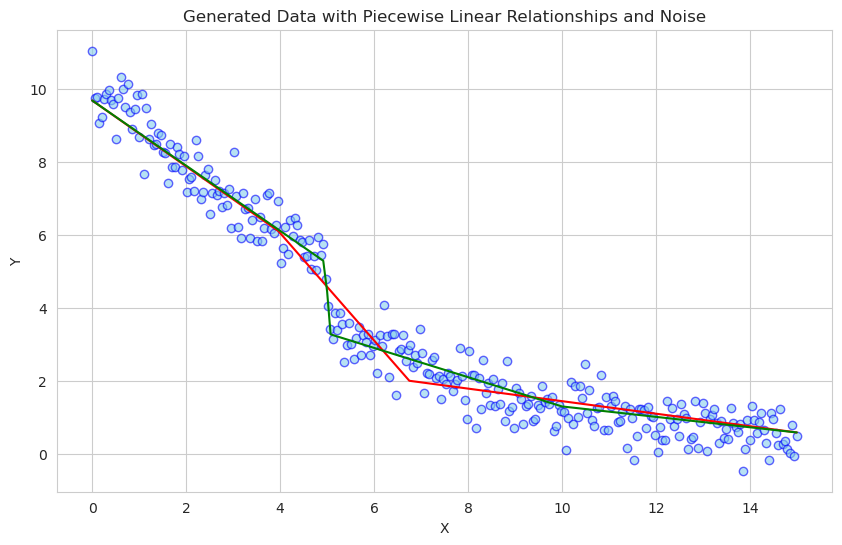

In [5]:
# now, we try to do it in a different way: we first average out the t_i and then estimate h
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(0, 15, 300)

# Calculate y values based on x values with different conditions and added noise
y = np.piecewise(x, [x < 5, (x >= 5) & (x < 10), x >= 10],
                 [lambda x: -x + 10 + np.random.normal(0, 0.5, size=x.shape),
                  lambda x: -0.5 * x + 6 + np.random.normal(0, 0.5, size=x.shape),
                  lambda x: -0.25 * x +4+ np.random.normal(0, 0.5, size=x.shape)])
px0, py0 = piecewise_linearRegression(x, y, fixed_break=[], maxcount=3)
px1, py1 = piecewise_linearRegression(x, y, fixed_break=[5, 10], maxcount=3)
# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, edgecolor='b', color='skyblue')
plt.plot(px0, py0, color='r', label='Piecewise Linear Regression without Fixed Breakpoints')
plt.plot(px1, py1, color='g', label='Piecewise Linear Regression with Fixed Breakpoints')
plt.title('Generated Data with Piecewise Linear Relationships and Noise')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()
